In [8]:
#!conda install -y conda-forge::dlib

In [9]:
from pathlib import Path


path = str(Path().resolve())+"/Images/"

In [10]:
pImg1 = path + "Walter.jpg"
pImg2 = path + "Trump.jpg"

# Análisis de las imagenes 

In [11]:
import cv2 as cv
import numpy as np

img = cv.imread(pImg1)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
mask = np.zeros_like(img_gray)

img2 = cv.imread(pImg2)
img2_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

Vemos las dos imagenes con las que vamos a generar en su escala RGB para ver su estado actual

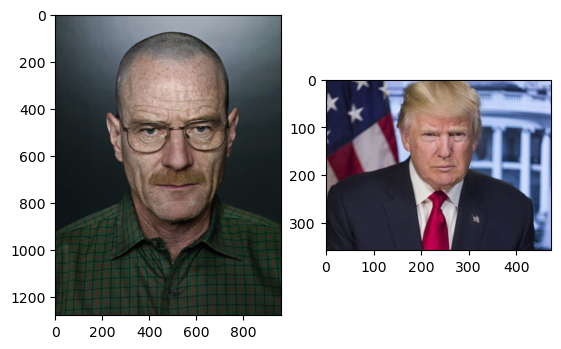

In [12]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(img2)

Ahora con el archivo data_set importamos la constante TRIANGLE_SET que es la triangulación de la cara añadido por mi parte ojos y boca a mayores
- Recogemos cada 3 valores de la lista
- Lo convertimos en una tupla de 3 valores que representan las triangulaciones cada una con su unión

In [13]:
from mediapipe.python.solutions import drawing_utils as mp_drawing
import mediapipe.python.solutions.face_mesh as mp_faces
from mediapipe.python.solutions import drawing_styles
import data_set as dts

listX=dts.TRIANGLE_SET
lista = [listX[i:i+3] for i in range(0, len(listX), 3)]
lista

[[(127, 34), (34, 139), (139, 127)],
 [(11, 0), (0, 37), (37, 11)],
 [(232, 231), (231, 120), (120, 232)],
 [(72, 37), (37, 39), (39, 72)],
 [(128, 121), (121, 47), (47, 128)],
 [(232, 121), (121, 128), (128, 232)],
 [(104, 69), (69, 67), (67, 104)],
 [(175, 171), (171, 148), (148, 175)],
 [(118, 50), (50, 101), (101, 118)],
 [(73, 39), (39, 40), (40, 73)],
 [(9, 151), (151, 108), (108, 9)],
 [(48, 115), (115, 131), (131, 48)],
 [(194, 204), (204, 211), (211, 194)],
 [(74, 40), (40, 185), (185, 74)],
 [(80, 42), (42, 183), (183, 80)],
 [(40, 92), (92, 186), (186, 40)],
 [(230, 229), (229, 118), (118, 230)],
 [(202, 212), (212, 214), (214, 202)],
 [(83, 18), (18, 17), (17, 83)],
 [(76, 61), (61, 146), (146, 76)],
 [(160, 29), (29, 30), (30, 160)],
 [(56, 157), (157, 173), (173, 56)],
 [(106, 204), (204, 194), (194, 106)],
 [(135, 214), (214, 192), (192, 135)],
 [(203, 165), (165, 98), (98, 203)],
 [(21, 71), (71, 68), (68, 21)],
 [(51, 45), (45, 4), (4, 51)],
 [(144, 24), (24, 23), (23,

Realizamos una prueba para ver el comportamiento de los puntos rojos en la imagen de los modelos

In [14]:
from numpy import isin
import numpy as np

landmarkListImg1=[]
with mp_faces.FaceMesh() as faces:
    results = faces.process(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    for face_landmarks in results.multi_face_landmarks:
        landmarkListImg1 = [x for x in face_landmarks.landmark]

with mp_faces.FaceMesh() as faces:
    results = faces.process(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
    for face_landmarks in results.multi_face_landmarks:
        landmarkListImg2 = [x for x in face_landmarks.landmark]

height, width = img.shape[:2]
img_m = img.copy()
triangulosImg1Marks={}
for valor in lista:
    for tupla in valor:
        x1,y1=landmarkListImg1[tupla[0]].x*width,landmarkListImg1[tupla[0]].y*height
        x2,y2=landmarkListImg1[tupla[1]].x*width,landmarkListImg1[tupla[1]].y*height
        cv.line(img_m, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 1)
        triangulosImg1Marks[tupla[0]]=[x1,y1]
        triangulosImg1Marks[tupla[0]]=[x2,y2]

height, width = img2.shape[:2]
img2_m = img2.copy()
triangulosImg2Marks={}
for valor in lista:
    for tupla in valor:
        x1,y1=landmarkListImg2[tupla[0]].x*width,landmarkListImg2[tupla[0]].y*height
        x2,y2=landmarkListImg2[tupla[1]].x*width,landmarkListImg2[tupla[1]].y*height
        cv.line(img2_m, (int(x1),int(y1)), (int(x2),int(y2)), 255)
        triangulosImg2Marks[tupla[0]]=[x1,y1]
        triangulosImg2Marks[tupla[0]]=[x2,y2]


c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\ia\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Vemos las triangulaciones de la cara de color rojo vemos que los recoge sin problema si son reconocibles en la imagen

<span style="color:red">SI LA IMAGEN NO ES RECONOCIDA AQUÍ NO VA EJECUTAR EL RESTO DEL RECONOCIMIENTO</span>


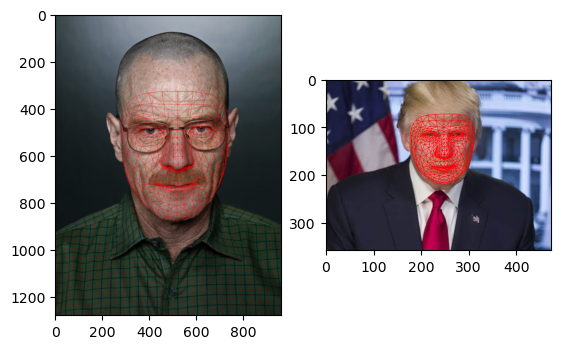

In [15]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(img_m)
axs[1].imshow(img2_m)

Formateamos la lista que pasa de:
- <span style="color:yellow">De un array de 3 x 2 de valores de las uniones del triangulo</span>
- <span style="color:green">A un solo array de 1 x 3 de valores que representa directamente la triangulación</span>

In [16]:
triangles=[]
for t in lista:
    pt1 = (t[0][0], t[0][1])
    pt2 = (t[1][0], t[1][1])
    pt3 = (t[2][0], t[2][1])
    value = list(set([pt1[0],pt1[1],pt2[0],pt2[1],pt3[0],pt3[1]]))
    triangles.append(value)
print(triangles)

[[34, 139, 127], [0, 11, 37], [232, 120, 231], [72, 37, 39], [128, 121, 47], [232, 121, 128], [104, 67, 69], [171, 148, 175], [50, 101, 118], [40, 73, 39], [9, 108, 151], [48, 115, 131], [194, 211, 204], [40, 185, 74], [80, 42, 183], [40, 186, 92], [118, 229, 230], [202, 212, 214], [17, 18, 83], [146, 76, 61], [160, 29, 30], [56, 157, 173], [194, 106, 204], [192, 214, 135], [98, 203, 165], [68, 21, 71], [51, 4, 45], [144, 24, 23], [146, 91, 77], [50, 187, 205], [200, 201, 18], [106, 91, 182], [90, 91, 181], [17, 84, 85], [203, 36, 206], [140, 171, 148], [40, 92, 39], [193, 244, 189], [28, 158, 159], [161, 246, 247], [196, 3, 236], [104, 68, 54], [168, 193, 8], [228, 117, 31], [193, 189, 55], [97, 98, 99], [100, 126, 47], [218, 166, 79], [26, 154, 155], [209, 131, 49], [136, 150, 135], [217, 126, 47], [52, 53, 223], [51, 45, 134], [170, 211, 140], [67, 108, 69], [91, 106, 43], [120, 230, 119], [226, 247, 130], [52, 53, 63], [242, 20, 238], [70, 156, 46], [62, 96, 78], [53, 46, 63], [34,

# Comienzo de práctica

In [17]:
img = cv.imread(pImg1)
img2 = cv.imread(pImg2)

## Recogida de puntos inicialies de las caras

In [18]:
import cv2
import numpy as np
import mediapipe as mp

mp_face_mesh = mp.solutions.face_mesh

# Configura la detección facial de MediaPipe
with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
    """Le indicamos que va ser una imagen estática, ya que los puntos los sacamos de la misma imagen, si fuera un video no indicabamos este apartado
    """

    # Procesa la imagen 1
    results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Procesamos cada uno de los puntos de la imagen, multiplicando su X e Y por su ancho y largo, recordatorio que el X e Y están cambiados en OpenCV
            landmarks_points = [(int(landmark.x * img.shape[1]), int(landmark.y * img.shape[0])) for landmark in face_landmarks.landmark]

    # Procesa la imagen 2
    results = face_mesh.process(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Mismo que la anterior imagen
            landmarks_points2 = [(int(landmark.x * img2.shape[1]), int(landmark.y * img2.shape[0])) for landmark in face_landmarks.landmark]

## Recogida de triángulos de la cara

In [26]:

def get_face(imagen1,imagen2,land1,land2):
    """Devuelve la cara extraida y adaptada a la imagen que se le va hacer el acople

    Args:
        imagen1 (Array Object Np.Int(X)): Imagen donde vamos a extraer la cara de ahí
        imagen2 (Array Object Np.Int(X)): Imagen 2 la cual recogeremos la posición de sus puntos y la usaremos para adaptar la imagen1
        land1 (Array Tuple (X,Y)): LandmarkPoints de la primera Imagen
        land2 (Array Tuple (X,Y)): LandmarkPoints de la segunda imagen

    Returns:
        Array Object Np.Int(X): Nueva imagen con solo la cara adaptados los puntos a la posición de la imagen
    """

    # Array de la unión de los triangulos
    global triangles

    # Transformamos la imagen donde vamos a sacar la cara a escala de gris, 
    # Creamos un np.array basado en la imagen de grises y otra de la imagen que tenemos que adaptar la forma de la imagen
    img_gray = cv2.cvtColor(imagen1, cv2.COLOR_BGR2GRAY)
    lines_space_mask = np.zeros_like(img_gray)
    img2_new_face = np.zeros_like(imagen2)
    
    triangles = np.array(triangles)

    # region Función Calculada
    def triangle_f(triangle_index):
        """Función definida para ejecutar de manera recursiva manejada por Numpy por su capa de C para optimización

        Args:
            triangle_index (Array Tuple (X1,X2,X3)): Cada uno de los indices de los triangulos
        """
        # region Imagen 1 Tratamiento
        # Sacamos los landmarks de la imagen actual y lo convertimos a un np.array de int32 ya que openCV no permite floats para el manejo de acciones
        tr1_pts = [land1[idx] for idx in triangle_index]
        triangle1 = np.array(tr1_pts, np.int32)
        
        # boundingRect devuelve un conjunto de 4 parametros la coordenada x,y y el width y height del array
        rect1 = cv2.boundingRect(triangle1)
        x, y, w, h = rect1

        # Sacamos el triangulo que coorresponde a la posición y hasta el height correspondiente y viceversa con x
        # Recordemos que openCV maneja X e Y al revés
        cropped_triangle = imagen1[y:y + h, x:x + w]

        # Creamos una máscara que sea de zeros pero en vez de que se base de otro array le indicamos el Heigh y el Width del triángulo correspondiente
        cropped_tr1_mask = np.zeros((h, w), np.uint8)

        # Sacamos los puntos en un array de puntos de X e Y que quedaría con la siguiente estructura
        # [[X0,Y0],
        #  [X1,Y1],
        #  [X2,Y2]]
        # Siendo la matriz resultante 3 x 2
        points = np.array([[pt[0] - x, pt[1] - y] for pt in tr1_pts], np.int32)

        # Rellenamos los datos de la máscara creada del Height y el Width con un polígono
        cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

        # Lo mismo con la mascara de líneas vacía
        cv2.fillConvexPoly(lines_space_mask, triangle1, 255)
        # endregion

        # region Imagen 2 Tratamiento
        # Triangulación de la segunda cara con el mismo formato que la anterior
        tr2_pts = [land2[idx] for idx in triangle_index]
        triangle2 = np.array(tr2_pts, np.int32)

        # boundingRect devuelve un conjunto de 4 parametros la coordenada x,y y el width y height del array
        rect2 = cv2.boundingRect(triangle2)
        x, y, w, h = rect2
        cropped_tr2_mask = np.zeros((h, w), np.uint8)

        # Sacamos los puntos en un array de puntos de X e Y que quedaría con la siguiente estructura
        # [[X0,Y0],
        #  [X1,Y1],
        #  [X2,Y2]]
        # Siendo la matriz resultante 3 x 2
        points2 = np.array([[pt[0] - x, pt[1] - y] for pt in tr2_pts], np.int32)
        cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)
        # endregion

        # region Adaptación de la imagen

        # Convertimos los puntos calculados de cada imagen en array de numpy para evitar los petes
        points = np.float32(points)
        points2 = np.float32(points2)

        # Nos da un array M con el affine transform de los puntos 1 y los puntos 2
        M = cv2.getAffineTransform(points, points2)

        # Con el triángulo dado lo transformamos con el M calculado y la máscara  
        warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))

        # Ahora junta el triángulo en la imagen de la máscara
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

        # Con las coordenadas Y y X creamos el area de la cara
        img2_new_face_rect_area = img2_new_face[y:y + h, x:x + w]

        # Sacamos el Threshold de la imagen invertida y tendremos la máscara
        _, mask_triangles_designed = cv2.threshold(cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY_INV)

        # El triangulo ahora ya es el deseado
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

        # Y lo insertamos en la nueva imagen calculada
        img2_new_face[y:y + h, x:x + w] = cv2.add(img2_new_face_rect_area, warped_triangle)
        # endregion
    # endregion

    # Ejecutamos la función de NumPy de manera recursiva en el axis=1 para que ejecute de manera equitativa al for
    np.apply_along_axis(triangle_f,axis=1,arr=triangles)

    # Le añadimos una distorsión a la imagen para eliminar lineas negras
    img2_new_face = cv.GaussianBlur(src=img2_new_face, ksize=(5,5), sigmaX=5, sigmaY=5 )
    plt.imshow(img2_new_face)
    
    # Y retornamos
    return img2_new_face

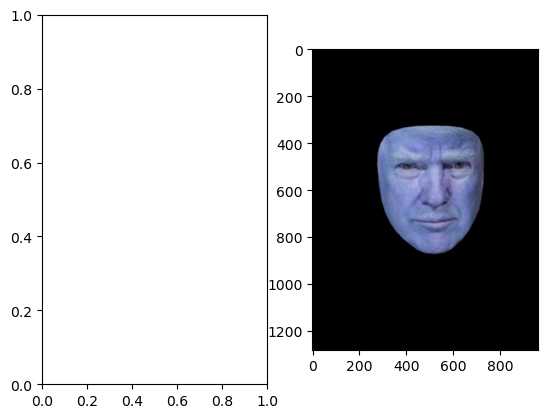

In [27]:
fig, axs = plt.subplots(1,2)

# Obtenemos las dos caras para ver como quedarían adaptadas a sus respectivas imagenes triángulo a triángulo
img1_f=get_face(img,img2,landmarks_points,landmarks_points2)
img2_f=get_face(img2,img,landmarks_points2,landmarks_points)
#axs[0].imshow(img1_f)
#axs[1].imshow(img2_f)

In [ ]:
def imagen_unida(imagen_original,face,landmarks_image):
    """Une la imagen donde se pondrá la cara con la cara sacada y sus puntos de landmarks

    Args:
        imagen_original (Array Object Np.Int(X)): Imagen donde se pondrá la cara
        face (Array Object Np.Int(X)): La cara sacada anteriormente
        landmarks_image (Array Tuple (X,Y)): Coordenadas X e Y de los puntos de orden 0 - len(NORMALIZED)

    Returns:
        (Array Object Np.Int(X)): Imagen modificada
    """
    convexhull2 = cv2.convexHull(np.array(landmarks_image, np.int32))
    img2_gray = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
    img2_gray = cv.GaussianBlur(src=img2_gray, ksize=(5,5), sigmaX=5, sigmaY=5)
    img2_face_mask = np.zeros_like(img2_gray)
    img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
    img2_face_mask = cv2.bitwise_not(img2_head_mask)

    img2_head_noface = cv2.bitwise_and(imagen_original, imagen_original, mask=img2_face_mask)
    result = cv2.add(img2_head_noface, face)

    (x, y, w, h) = cv2.boundingRect(convexhull2)
    center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

    seamlessclone = cv2.seamlessClone(result, imagen_original, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

    return cv2.cvtColor(seamlessclone,cv2.COLOR_BGR2RGB)

In [ ]:
final1=imagen_unida(img2,img1_f,landmarks_points2)
final2=imagen_unida(img,img2_f,landmarks_points)
fig, axs = plt.subplots(1,2)
axs[0].imshow(final1)
axs[1].imshow(final2)

In [ ]:
imagen = img

landmark=landmarks_points

video = cv.VideoCapture(0)

# Especificamos las características del modelo detector de caras
with mp_face_mesh.FaceMesh(static_image_mode=False,max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
    while(True):

        # Recogemos el frame del video actual
        ret, frame = video.read()
        if ret == True:
            frame = cv.flip(frame, 1)

            # Procesamiento del frame por el resultado
            results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    landmarks_points_f = [(int(landmark.x * frame.shape[1]), int(landmark.y * frame.shape[0])) for landmark in face_landmarks.landmark]
                try:

                    # Con el video actual saca la cara y la une con el resto de nuesra cara actual
                    annotated_image=get_face(imagen,frame,landmark,landmarks_points_f)
                    final1=imagen_unida(frame,annotated_image,landmarks_points_f)
                except:
                    final1 = frame
                cv.imshow("Salida", cv.cvtColor(final1,cv.COLOR_BGR2RGB))
            cv.imshow("Cara normal", cv.cvtColor(frame,cv.COLOR_BGR2RGB))
        if ret == False:
            video.set(cv.CAP_PROP_POS_FRAMES, 0)
        if cv.waitKey(10) & 0xFF == 27: break
    
video.release()
cv.destroyAllWindows()